#제주 핫 플레이스 지도에 표시하기

### 데이터 준비

In [1]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving 제주핫플레이스.csv to 제주핫플레이스.csv


In [2]:
import pandas as pd
raw_df = pd.read_csv(filename)
raw_df.head()

,content,date,like,place,tags
0,더 늦기전에 제주도로 떠나쟈😍.#제주핫플레이스 간단히 1탄 모아봄!#제주여행 요 필...,2018-12-07,"1,402",NaN,"['#제주핫플레이스', '#제주여행', '#제주여행', '#제주도여행', '#제주가..."
1,12월에 제주도를 가야하는이유🍊.#제주핫플 모음 끝판왕😍이거 하나면 겨울 #제주여행...,2018-12-03,368,NaN,"['#제주핫플', '#제주여행', '#제주', '#제주도', '#제주도맛집', '#..."
2,11월 놓치지 말아야 할 제주 관광.가을바람이 최고조에 이르는 11월추운 겨울을 앞...,2018-11-02,166,NaN,"['#honestin', '#어니스틴', '#제주여행', '#제주', '#제주도',..."
3,국민학교세대#제주관광#제주살이#제주이주민#아라동주민#삼남매집 #새해첫날#드라이브#명...,2019-01-01,28,명월국민학교,"['#제주관광', '#제주살이', '#제주이주민', '#아라동주민', '#삼남매집'..."
4,#제주관광 #제주 #돔나이트 #스트레스 #풀자 #춤추며 #땀날려 #가끔은괜찮아 #인...,2019-01-01,12,NaN,"['#제주관광', '#제주', '#돔나이트', '#스트레스', '#풀자', '#춤추..."


In [4]:
location_counts = raw_df.place.value_counts().to_frame()
print(location_counts.shape)
location_counts.head()

(1027, 1)


,place
Jeju,241
Jeju-do,172
Jungle Book by Alice,101
Seogwipo,65
제주도 크리스마스 박물관,59


In [5]:
location_counts.tail()

,place
해물뚝배기전문 재암식당,1
귀덕1리,1
수카사,1
푸릇프릍,1
쿠쿠아림,1


In [6]:
location_counts.to_csv('location_counts.csv')

In [8]:
loc_df = pd.read_csv('location_counts.csv')
loc_df.columns = ['지명','빈도']
loc_df.head()

,지명,빈도
0,Jeju,241
1,Jeju-do,172
2,Jungle Book by Alice,101
3,Seogwipo,65
4,제주도 크리스마스 박물관,59


### 2. 카카오 검색 API를 이용한 장소 검색
- 키워드 장소 검색

In [9]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving kakaoapikey.txt to kakaoapikey.txt


In [10]:
with open(filename) as f:
  api_key = f.read()

In [11]:
import requests
from urllib.parse import quote

In [16]:
keyword = '합정 스타벅스'
search_url = 'http://dapi.kakao.com/v2/local/search/keyword.json'
url = f'{search_url}?query={quote(keyword)}'
# Authorization: KakaoAK {REST_API_KEY}
result = requests.get(url,
                      headers={"Authorization":f'KakaoAK {api_key}'}).json()
result['documents'][0]

{'address_name': '서울 마포구 서교동 395-166',
 'category_group_code': 'CE7',
 'category_group_name': '카페',
 'category_name': '음식점 > 카페 > 커피전문점 > 스타벅스',
 'distance': '',
 'id': '26572121',
 'phone': '1522-3232',
 'place_name': '스타벅스 서교점',
 'place_url': 'http://place.map.kakao.com/26572121',
 'road_address_name': '서울 마포구 양화로 78',
 'x': '126.916980454434',
 'y': '37.5514601750423'}

In [26]:
import numpy as np

In [50]:
import re
hangul = re.compile('[^ 가-힣0-9]+')

In [46]:
def find_place(keyword):
  url = f'{search_url}?query={quote(keyword)}'
  result = requests.get(url,
                        headers={"Authorization":f'KakaoAK {api_key}'}).json()
  try:
    name = result['documents'][0]['place_name']
    lng = float(result['documents'][0]['x'])
    lat = float(result['documents'][0]['y'])
  except:
    name =  ''
    lng = np.nan
    lat = np.nan
    print(keyword)
  return name, lng, lat, keyword

In [31]:
find_place('제주공항')

제주공항


('제주국제공항', 126.492769004244, 33.5070789578184, '제주공항')

In [ ]:
# loc_df에 공식명칭, 위도, 경도 추가
name_list, lng_list, lat_list = [], [], []
for keyword in loc_df.지명:
  keyword = hangul.sub('',keyword).strip()
  if keyword:
    name, lng, lat, _ = find_place(keyword)
  else:
    name, lng, lat = '', np.nan, np.nan
  name_list.append(name)
  lng_list.append(lng)
  lat_list.append(lat)


In [52]:
loc_df['공식명칭'] = name_list
loc_df['위도'] = lat_list
loc_df['경도'] = lng_list
loc_df.head()

,지명,빈도,공식명칭,위도,경도
0,Jeju,241,,NaN,NaN
1,Jeju-do,172,,NaN,NaN
2,Jungle Book by Alice,101,,NaN,NaN
3,Seogwipo,65,,NaN,NaN
4,제주도 크리스마스 박물관,59,바이나흐튼 크리스마스박물관,33.291572,126.327858


In [54]:
# Null 데이터 유무 확인
loc_df.isna().sum()  # isna = isnull 

지명        0
빈도        0
공식명칭      0
위도      197
경도      197
dtype: int64

In [71]:
# Null 데이터 삭제
total_df = loc_df.dropna()         # Null 값이 있는 행을 삭제
total_df.isnull().sum()

지명      0
빈도      0
공식명칭    0
위도      0
경도      0
dtype: int64

In [72]:
total_df.head()

,지명,빈도,공식명칭,위도,경도
4,제주도 크리스마스 박물관,59,바이나흐튼 크리스마스박물관,33.291572,126.327858
5,제주에인감귤밭,48,제주에인감귤밭,33.256561,126.539014
7,성산일출봉 城山日出峰 Seongsan Ilchulbong,36,성산일출봉,33.459135,126.940538
8,폼포코식당_pompokokitchen,30,폼포코식당,33.450408,126.919065
9,1100고지,25,한라산1100고지,33.358078,126.462220


### 3. 공식명칭으로 데이터 정리

In [59]:
# 공식명칭 중복 여부
df.공식명칭.value_counts()[:10]

올레길 7코스(서귀포-월평 올레)    6
동문재래시장                4
함덕해수욕장                4
협재해수욕장                3
비자림                   3
우도                    3
이호테우해수욕장              3
제주중문관광단지              3
한라산국립공원               3
세화해변                  3
Name: 공식명칭, dtype: int64

In [73]:
df = df.pivot_table(index=['공식명칭','위도','경도'], values='빈도', aggfunc='sum')
df.tail()

,,,빈도
공식명칭,위도,경도,
휘닉스제주섭지코지 제주,33.430497,126.928187,1
휴애리자연생활공원,33.309410,126.635410,11
흑돼지가있는풍경 본점,33.475376,126.480646,1
흑송,35.175011,129.196513,1
히든클리프호텔&네이쳐,33.254776,126.402595,5


In [74]:
df.reset_index(inplace=True)
df.공식명칭.value_counts()[:5]

황우지해안      1
연정식당       1
마레보리조트     1
세화해변       1
운정이네 본점    1
Name: 공식명칭, dtype: int64

In [70]:
df.to_csv('공식명칭.csv',index=False)

### 3. folium 지도 시각화

- 1.개별 표시

In [75]:
  df.sort_values(by='빈도',ascending=False).head(10)

,공식명칭,위도,경도,빈도
230,바이나흐튼 크리스마스박물관,33.291572,126.327858,59
540,제주에인감귤밭,33.256561,126.539014,48
319,성산일출봉,33.459135,126.940538,38
664,폼포코식당,33.450408,126.919065,30
692,한라산1100고지,33.358078,126.462220,25
474,위미동백나무군락,33.272939,126.674731,24
472,월정리해수욕장,33.556469,126.795805,22
446,올레길 7코스(서귀포-월평 올레),33.237386,126.515310,21
29,고집돌우럭 중문점,33.257981,126.416705,21
725,협재해수욕장,33.393866,126.239158,20


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)


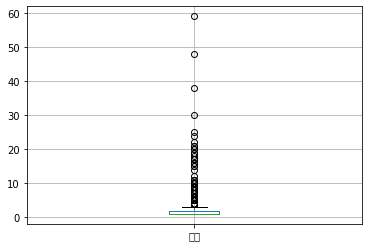

In [77]:
df[['빈도']].boxplot()

In [78]:
import folium

In [86]:
Mt_Hanla = [33.3625, 126.533694]
map = folium.Map(location=Mt_Hanla, zoom_start=10.5)
for i in df.index:
  folium.CircleMarker(
      radius=int(df.빈도[i]),            # int64는 처리 불가
      location=[df.위도[i],df.경도[i]],
      popup=folium.Popup(df.공식명칭[i], max_width=200),
      tooltip=df.공식명칭[i],
      color='crimson'
  ).add_to(map)
map

- 2.그룹으로 표시

In [89]:
from folium.plugins import MarkerCluster

locations, names = [], []
for i in df.index:
  locations.append([df.위도[i], df.경도[i]])
  names.append(df.공식명칭[i])


In [91]:
map = folium.Map(location=Mt_Hanla, zoom_start=11)
MarkerCluster(
    locations=locations, popups=names,
    name='제주', overlay=True, control=True
).add_to(map)
map